# Word Embedding avec l'utilisation de tensorflow keras

In [272]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import csv
import nltk
import io

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

from nltk.cluster import KMeansClusterer
from nltk.tokenize import word_tokenize

from sklearn import cluster
from sklearn import metrics

from tensorflow.keras.preprocessing.text import one_hot
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Création d'un réseau de neurones à partir de vecteurs de mots

In [273]:
vocab_size = 1000
embedding_dim = 16
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

### Récupérer nos données

In [274]:
data = pd.read_csv("my_csv_clean.csv",sep = ',') #we got that csv after running the Text Preprocessing file
data.columns = ['tweet', 'class']
    
X = data['tweet']
y = data['class'] 

categories = ["NotSexist", "Sexist"]

X_train, X_test, y_train , y_test = train_test_split(X , y ,test_size=0.3)

X = list(X)
y = [categories[i] for i in y]
X_train = list(X_train)
X_test = list(X_test)
y_train = [categories[i] for i in y_train]
y_test = [categories[i] for i in y_test]
#print(y_train)

### Tokeniser les phrases

In [275]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

In [276]:
word_index = tokenizer.word_index
total_words = len(word_index)+1 # le +1 est pour le OOV
#print("Total_words = ", total_words)
#print("Word index : \n", word_index)

In [277]:
train_sequences = tokenizer.texts_to_sequences(X_train)
train_filled = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

validation_sequences = tokenizer.texts_to_sequences(X_test)
validation_filled = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)

### Tokeniser les catégories

In [278]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(y)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(y_train))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(y_test))

### Création du modèle

In [279]:
modele = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])
modele.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
modele.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_28 (Embedding)    (None, 120, 16)           16000     
                                                                 
 global_average_pooling1d_28  (None, 16)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_56 (Dense)            (None, 24)                408       
                                                                 
 dense_57 (Dense)            (None, 6)                 150       
                                                                 
Total params: 16,558
Trainable params: 16,558
Non-trainable params: 0
_________________________________________________________________


In [280]:
num_epochs = 30
history = modele.fit(train_filled, training_label_seq, epochs=num_epochs, 
                    validation_data=(validation_filled, validation_label_seq), 
                    verbose=2)

Epoch 1/30
69/69 - 1s - loss: 1.5957 - accuracy: 0.6473 - val_loss: 1.3218 - val_accuracy: 0.7037 - 722ms/epoch - 10ms/step
Epoch 2/30
69/69 - 0s - loss: 0.9990 - accuracy: 0.6782 - val_loss: 0.7387 - val_accuracy: 0.7037 - 188ms/epoch - 3ms/step
Epoch 3/30
69/69 - 0s - loss: 0.7055 - accuracy: 0.6782 - val_loss: 0.6466 - val_accuracy: 0.7037 - 191ms/epoch - 3ms/step
Epoch 4/30
69/69 - 0s - loss: 0.6526 - accuracy: 0.6782 - val_loss: 0.6217 - val_accuracy: 0.7037 - 192ms/epoch - 3ms/step
Epoch 5/30
69/69 - 0s - loss: 0.6382 - accuracy: 0.6782 - val_loss: 0.6137 - val_accuracy: 0.7037 - 178ms/epoch - 3ms/step
Epoch 6/30
69/69 - 0s - loss: 0.6318 - accuracy: 0.6782 - val_loss: 0.6104 - val_accuracy: 0.7037 - 180ms/epoch - 3ms/step
Epoch 7/30
69/69 - 0s - loss: 0.6282 - accuracy: 0.6782 - val_loss: 0.6106 - val_accuracy: 0.7037 - 203ms/epoch - 3ms/step
Epoch 8/30
69/69 - 0s - loss: 0.6259 - accuracy: 0.6782 - val_loss: 0.6105 - val_accuracy: 0.7037 - 178ms/epoch - 3ms/step
Epoch 9/30
69/6

### Représentation graphique des différentes accuracy obtenues

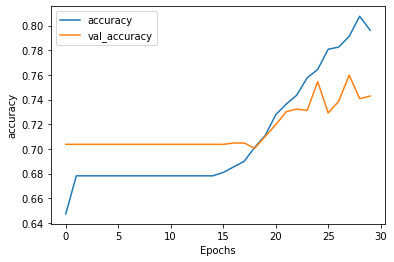

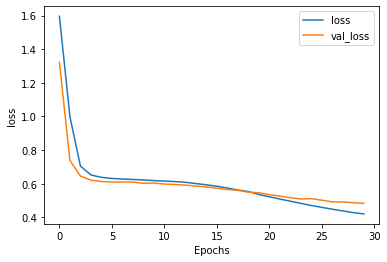

In [281]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [282]:
y_pred = modele.predict(validation_filled)
predictions = np.argmax(y_pred,axis=1)

for i in range(len(predictions)):
    predictions[i] = predictions[i] - 1
    
true_labels = []
for i in y_test:
    if(i=='NotSexist'):
        true_labels.append(0)
    else:
        true_labels.append(1)
    
print("Accuracy : ", np.mean(predictions == true_labels))
print("Matrice de confusion :")
print(metrics.confusion_matrix(true_labels, predictions))
print(metrics.classification_report(true_labels, predictions,target_names=categories))

Accuracy :  0.7428571428571429
Matrice de confusion :
[[610  55]
 [188  92]]
              precision    recall  f1-score   support

   NotSexist       0.76      0.92      0.83       665
      Sexist       0.63      0.33      0.43       280

    accuracy                           0.74       945
   macro avg       0.70      0.62      0.63       945
weighted avg       0.72      0.74      0.71       945



### Pour la visualisation de nos vecteurs de mots sur https://projector.tensorflow.org/

In [283]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [284]:
e = modele.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

(1000, 16)


In [285]:
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [286]:
#On a essayé d'ajouter des poids à certains mots, malheureusement sans succès
'''import re
stereotype_liste = []

with open('stereotype_liste.txt',encoding='utf8') as f:
    stereotype_liste = f.readlines()

weighted_words = [re.sub(r"\n",'',i) for i in stereotype_liste]

print(weighted_words)

from sklearn.feature_extraction.text import TfidfVectorizer
   
data = pd.read_csv("my_csv_clean.csv",sep = ',') #we got that csv after running the Text Preprocessing file
data.columns = ['tweet', 'class'] 

X = data['tweet']
y = data['class'] 

categories = ["NotSexist", "Sexist"]

vectorizer = TfidfVectorizer()
new_X = vectorizer.fit_transform(X)
vectorizer.get_feature_names_out()'''

'import re\nstereotype_liste = []\n\nwith open(\'stereotype_liste.txt\',encoding=\'utf8\') as f:\n    stereotype_liste = f.readlines()\n\nweighted_words = [re.sub(r"\n",\'\',i) for i in stereotype_liste]\n\nprint(weighted_words)\n\nfrom sklearn.feature_extraction.text import TfidfVectorizer\n   \ndata = pd.read_csv("my_csv_clean.csv",sep = \',\') #we got that csv after running the Text Preprocessing file\ndata.columns = [\'tweet\', \'class\'] \n\nX = data[\'tweet\']\ny = data[\'class\'] \n\ncategories = ["NotSexist", "Sexist"]\n\nvectorizer = TfidfVectorizer()\nnew_X = vectorizer.fit_transform(X)\nvectorizer.get_feature_names_out()'

## Création d'un réseau de neurone à partir de vecteur de mots avec recours à de l'oversampling

In [287]:
data = pd.read_csv("my_csv_clean.csv",sep = ',') #we got that csv after running the Text Preprocessing file
data.columns = ['tweet', 'class']

X = data['tweet']
y = data['class'] 

X_train, X_test, y_train , y_test = train_test_split(X , y ,test_size=0.3)

X = list(X)
y = [categories[i] for i in y]
X_test = list(X_test)
y_train = [categories[i] for i in y_train]
y_test = [categories[i] for i in y_test]

ros = RandomOverSampler()
X_ros_train, y_ros_train = ros.fit_resample(np.array(X_train).reshape(-1,1), y_train)# new class distribution 
X_ros_test, y_ros_test = ros.fit_resample(np.array(X_test).reshape(-1,1), y_test)# new class distribution 
X_ros_train = X_ros_train.tolist()
X_ros_test = X_ros_test.tolist()

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_ros_train)

word_index = tokenizer.word_index
total_words = len(word_index)+1 #1 for oov word

train_sequences = tokenizer.texts_to_sequences(X_ros_train)
train_filled = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

validation_sequences = tokenizer.texts_to_sequences(X_ros_test)
validation_filled = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)

label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(y)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(y_ros_train))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(y_ros_test))

modele = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])
modele.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
modele.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_29 (Embedding)    (None, 120, 16)           16000     
                                                                 
 global_average_pooling1d_29  (None, 16)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_58 (Dense)            (None, 24)                408       
                                                                 
 dense_59 (Dense)            (None, 6)                 150       
                                                                 
Total params: 16,558
Trainable params: 16,558
Non-trainable params: 0
_________________________________________________________________


In [288]:
num_epochs = 30
history = modele.fit(train_filled, training_label_seq, epochs=num_epochs, 
                    validation_data=(validation_filled, validation_label_seq), 
                    verbose=2)

Epoch 1/30
95/95 - 1s - loss: 1.5831 - accuracy: 0.4472 - val_loss: 1.2031 - val_accuracy: 0.5000 - 769ms/epoch - 8ms/step
Epoch 2/30
95/95 - 0s - loss: 0.8804 - accuracy: 0.4927 - val_loss: 0.7322 - val_accuracy: 0.5000 - 243ms/epoch - 3ms/step
Epoch 3/30
95/95 - 0s - loss: 0.7141 - accuracy: 0.4934 - val_loss: 0.7039 - val_accuracy: 0.5000 - 269ms/epoch - 3ms/step
Epoch 4/30
95/95 - 0s - loss: 0.7003 - accuracy: 0.5096 - val_loss: 0.6987 - val_accuracy: 0.5000 - 242ms/epoch - 3ms/step
Epoch 5/30
95/95 - 0s - loss: 0.6970 - accuracy: 0.5116 - val_loss: 0.6982 - val_accuracy: 0.5000 - 251ms/epoch - 3ms/step
Epoch 6/30
95/95 - 0s - loss: 0.6941 - accuracy: 0.5697 - val_loss: 0.6961 - val_accuracy: 0.5000 - 252ms/epoch - 3ms/step
Epoch 7/30
95/95 - 0s - loss: 0.6936 - accuracy: 0.5489 - val_loss: 0.6949 - val_accuracy: 0.5000 - 234ms/epoch - 2ms/step
Epoch 8/30
95/95 - 0s - loss: 0.6920 - accuracy: 0.5251 - val_loss: 0.6945 - val_accuracy: 0.4860 - 248ms/epoch - 3ms/step
Epoch 9/30
95/95

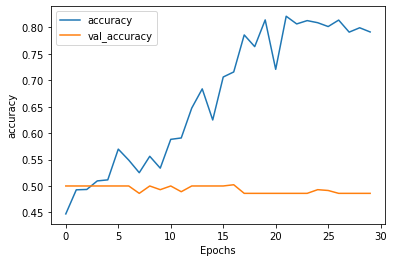

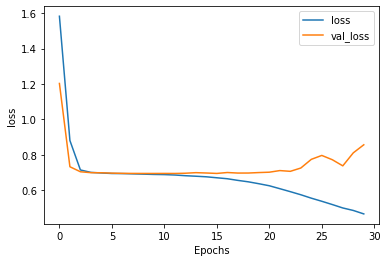

In [289]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [290]:
y_pred = modele.predict(validation_filled)
predictions = np.argmax(y_pred,axis=1)

for i in range(len(predictions)):
    predictions[i] = predictions[i] - 1
    
true_labels = []
for i in y_ros_test:
    if(i=='NotSexist'):
        true_labels.append(0)
    else:
        true_labels.append(1)
print("Accuracy : ", np.mean(predictions == true_labels))
print("Matrice de confusion :")
print(metrics.confusion_matrix(true_labels, predictions))
print(metrics.classification_report(true_labels, predictions,target_names=categories))

Accuracy :  0.48604651162790696
Matrice de confusion :
[[624  21]
 [642   3]]
              precision    recall  f1-score   support

   NotSexist       0.49      0.97      0.65       645
      Sexist       0.12      0.00      0.01       645

    accuracy                           0.49      1290
   macro avg       0.31      0.49      0.33      1290
weighted avg       0.31      0.49      0.33      1290



## Création d'un réseau de neurone à partir de vecteur de mots avec recours à de l'undersampling

In [291]:
data = pd.read_csv("my_csv_clean.csv",sep = ',') #we got that csv after running the Text Preprocessing file
data.columns = ['tweet', 'class']

X = data['tweet']
y = data['class'] 

X_train, X_test, y_train , y_test = train_test_split(X , y ,test_size=0.3)

X = list(X)
y = [categories[i] for i in y]
X_test = list(X_test)
y_train = [categories[i] for i in y_train]
y_test = [categories[i] for i in y_test]

rus = RandomUnderSampler()
X_rus_train, y_rus_train = rus.fit_resample(np.array(X_train).reshape(-1,1), y_train)# new class distribution 
X_rus_test, y_rus_test = rus.fit_resample(np.array(X_test).reshape(-1,1), y_test)# new class distribution 
X_rus_train = X_rus_train.tolist()
X_rus_test = X_rus_test.tolist()

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_rus_train)

word_index = tokenizer.word_index
total_words = len(word_index)+1

train_sequences = tokenizer.texts_to_sequences(X_rus_train)
train_filled = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

validation_sequences = tokenizer.texts_to_sequences(X_rus_test)
validation_filled = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)

label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(y)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(y_rus_train))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(y_rus_test))

modele = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])
modele.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
modele.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_30 (Embedding)    (None, 120, 16)           16000     
                                                                 
 global_average_pooling1d_30  (None, 16)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_60 (Dense)            (None, 24)                408       
                                                                 
 dense_61 (Dense)            (None, 6)                 150       
                                                                 
Total params: 16,558
Trainable params: 16,558
Non-trainable params: 0
_________________________________________________________________


In [292]:
num_epochs = 30
history = modele.fit(train_filled, training_label_seq, epochs=num_epochs, 
                    validation_data=(validation_filled, validation_label_seq), 
                    verbose=2)

Epoch 1/30
45/45 - 1s - loss: 1.6673 - accuracy: 0.5000 - val_loss: 1.5056 - val_accuracy: 0.5000 - 660ms/epoch - 15ms/step
Epoch 2/30
45/45 - 0s - loss: 1.2880 - accuracy: 0.5000 - val_loss: 1.0386 - val_accuracy: 0.5000 - 134ms/epoch - 3ms/step
Epoch 3/30
45/45 - 0s - loss: 0.8876 - accuracy: 0.5000 - val_loss: 0.7817 - val_accuracy: 0.5000 - 146ms/epoch - 3ms/step
Epoch 4/30
45/45 - 0s - loss: 0.7491 - accuracy: 0.4816 - val_loss: 0.7265 - val_accuracy: 0.5000 - 164ms/epoch - 4ms/step
Epoch 5/30
45/45 - 0s - loss: 0.7183 - accuracy: 0.5035 - val_loss: 0.7113 - val_accuracy: 0.5000 - 149ms/epoch - 3ms/step
Epoch 6/30
45/45 - 0s - loss: 0.7074 - accuracy: 0.4965 - val_loss: 0.7049 - val_accuracy: 0.5000 - 141ms/epoch - 3ms/step
Epoch 7/30
45/45 - 0s - loss: 0.7025 - accuracy: 0.5227 - val_loss: 0.7014 - val_accuracy: 0.5000 - 147ms/epoch - 3ms/step
Epoch 8/30
45/45 - 0s - loss: 0.7004 - accuracy: 0.5021 - val_loss: 0.6998 - val_accuracy: 0.5000 - 133ms/epoch - 3ms/step
Epoch 9/30
45/4

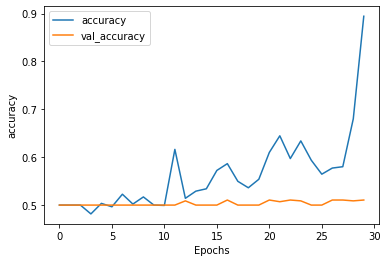

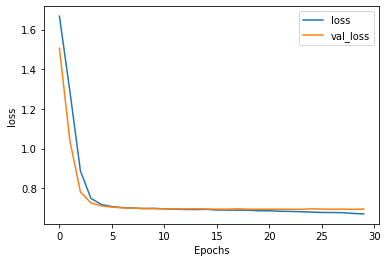

In [293]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [294]:
y_pred = modele.predict(validation_filled)
predictions = np.argmax(y_pred,axis=1)

for i in range(len(predictions)):
    predictions[i] = predictions[i] - 1
    
true_labels = []
for i in y_rus_test:
    if(i=='NotSexist'):
        true_labels.append(0)
    else:
        true_labels.append(1)
    
print("Accuracy : ", np.mean(predictions == true_labels))
print("Matrice de confusion :") 
print(metrics.confusion_matrix(true_labels, predictions))
print(metrics.classification_report(true_labels, predictions,target_names=categories))

Accuracy :  0.5105633802816901
Matrice de confusion :
[[  6 278]
 [  0 284]]
              precision    recall  f1-score   support

   NotSexist       1.00      0.02      0.04       284
      Sexist       0.51      1.00      0.67       284

    accuracy                           0.51       568
   macro avg       0.75      0.51      0.36       568
weighted avg       0.75      0.51      0.36       568



### Changement de paramètre du réseau initial - vocab size = 4000

In [295]:
vocab_size = 4000
embedding_dim = 16
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [296]:
data = pd.read_csv("my_csv_clean.csv",sep = ',') #we got that csv after running the Text Preprocessing file
data.columns = ['tweet', 'class']
    
X = data['tweet']
y = data['class'] 

categories = ["NotSexist", "Sexist"]

X_train, X_test, y_train , y_test = train_test_split(X , y ,test_size=0.3)

X = list(X)
y = [categories[i] for i in y]
X_train = list(X_train)
X_test = list(X_test)
y_train = [categories[i] for i in y_train]
y_test = [categories[i] for i in y_test]
#print(y_train)

In [297]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

In [298]:
word_index = tokenizer.word_index
total_words = len(word_index)+1 # le +1 est pour le OOV
#print("Total_words = ", total_words)
#print("Word index : \n", word_index)

In [299]:
train_sequences = tokenizer.texts_to_sequences(X_train)
train_filled = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

validation_sequences = tokenizer.texts_to_sequences(X_test)
validation_filled = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)

In [300]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(y)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(y_train))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(y_test))

In [301]:
modele = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])
modele.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
modele.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_31 (Embedding)    (None, 120, 16)           64000     
                                                                 
 global_average_pooling1d_31  (None, 16)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_62 (Dense)            (None, 24)                408       
                                                                 
 dense_63 (Dense)            (None, 6)                 150       
                                                                 
Total params: 64,558
Trainable params: 64,558
Non-trainable params: 0
_________________________________________________________________


In [302]:
num_epochs = 30
history = modele.fit(train_filled, training_label_seq, epochs=num_epochs, 
                    validation_data=(validation_filled, validation_label_seq), 
                    verbose=2)

Epoch 1/30
69/69 - 1s - loss: 1.6168 - accuracy: 0.2969 - val_loss: 1.3578 - val_accuracy: 0.3175 - 754ms/epoch - 11ms/step
Epoch 2/30
69/69 - 0s - loss: 1.0140 - accuracy: 0.5887 - val_loss: 0.7372 - val_accuracy: 0.6825 - 196ms/epoch - 3ms/step
Epoch 3/30
69/69 - 0s - loss: 0.6733 - accuracy: 0.6872 - val_loss: 0.6462 - val_accuracy: 0.6825 - 217ms/epoch - 3ms/step
Epoch 4/30
69/69 - 0s - loss: 0.6349 - accuracy: 0.6872 - val_loss: 0.6327 - val_accuracy: 0.6825 - 232ms/epoch - 3ms/step
Epoch 5/30
69/69 - 0s - loss: 0.6266 - accuracy: 0.6872 - val_loss: 0.6279 - val_accuracy: 0.6825 - 211ms/epoch - 3ms/step
Epoch 6/30
69/69 - 0s - loss: 0.6229 - accuracy: 0.6872 - val_loss: 0.6255 - val_accuracy: 0.6825 - 210ms/epoch - 3ms/step
Epoch 7/30
69/69 - 0s - loss: 0.6199 - accuracy: 0.6872 - val_loss: 0.6227 - val_accuracy: 0.6825 - 195ms/epoch - 3ms/step
Epoch 8/30
69/69 - 0s - loss: 0.6176 - accuracy: 0.6872 - val_loss: 0.6207 - val_accuracy: 0.6825 - 190ms/epoch - 3ms/step
Epoch 9/30
69/6

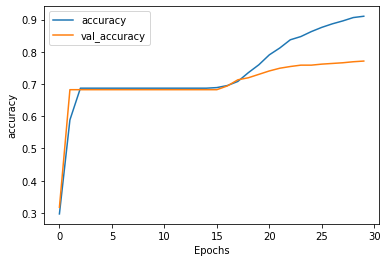

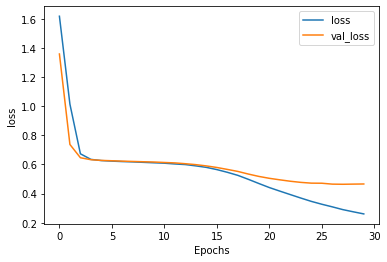

In [303]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [304]:
y_pred = modele.predict(validation_filled)
predictions = np.argmax(y_pred,axis=1)

for i in range(len(predictions)):
    predictions[i] = predictions[i] - 1
    
true_labels = []
for i in y_test:
    if(i=='NotSexist'):
        true_labels.append(0)
    else:
        true_labels.append(1)
    
print("Accuracy : ", np.mean(predictions == true_labels))
print("Matrice de confusion :")
print(metrics.confusion_matrix(true_labels, predictions))
print(metrics.classification_report(true_labels, predictions,target_names=categories))

Accuracy :  0.7714285714285715
Matrice de confusion :
[[579  66]
 [150 150]]
              precision    recall  f1-score   support

   NotSexist       0.79      0.90      0.84       645
      Sexist       0.69      0.50      0.58       300

    accuracy                           0.77       945
   macro avg       0.74      0.70      0.71       945
weighted avg       0.76      0.77      0.76       945



### Changement de paramètre du réseau initial - embedding_dim = 18

In [305]:
vocab_size = 1000
embedding_dim = 18
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [306]:
data = pd.read_csv("my_csv_clean.csv",sep = ',') #we got that csv after running the Text Preprocessing file
data.columns = ['tweet', 'class']
    
X = data['tweet']
y = data['class'] 

categories = ["NotSexist", "Sexist"]

X_train, X_test, y_train , y_test = train_test_split(X , y ,test_size=0.3)

X = list(X)
y = [categories[i] for i in y]
X_train = list(X_train)
X_test = list(X_test)
y_train = [categories[i] for i in y_train]
y_test = [categories[i] for i in y_test]
#print(y_train)

In [307]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

In [308]:
word_index = tokenizer.word_index
total_words = len(word_index)+1 # le +1 est pour le OOV
#print("Total_words = ", total_words)
#print("Word index : \n", word_index)

In [309]:
train_sequences = tokenizer.texts_to_sequences(X_train)
train_filled = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

validation_sequences = tokenizer.texts_to_sequences(X_test)
validation_filled = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)

In [310]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(y)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(y_train))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(y_test))

In [311]:
modele = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])
modele.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
modele.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_32 (Embedding)    (None, 120, 18)           18000     
                                                                 
 global_average_pooling1d_32  (None, 18)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_64 (Dense)            (None, 24)                456       
                                                                 
 dense_65 (Dense)            (None, 6)                 150       
                                                                 
Total params: 18,606
Trainable params: 18,606
Non-trainable params: 0
_________________________________________________________________


In [312]:
num_epochs = 30
history = modele.fit(train_filled, training_label_seq, epochs=num_epochs, 
                    validation_data=(validation_filled, validation_label_seq), 
                    verbose=2)

Epoch 1/30
69/69 - 1s - loss: 1.5284 - accuracy: 0.6854 - val_loss: 1.1757 - val_accuracy: 0.6868 - 1s/epoch - 20ms/step
Epoch 2/30
69/69 - 0s - loss: 0.8653 - accuracy: 0.6854 - val_loss: 0.6939 - val_accuracy: 0.6868 - 240ms/epoch - 3ms/step
Epoch 3/30
69/69 - 0s - loss: 0.6609 - accuracy: 0.6854 - val_loss: 0.6397 - val_accuracy: 0.6868 - 271ms/epoch - 4ms/step
Epoch 4/30
69/69 - 0s - loss: 0.6345 - accuracy: 0.6854 - val_loss: 0.6285 - val_accuracy: 0.6868 - 411ms/epoch - 6ms/step
Epoch 5/30
69/69 - 0s - loss: 0.6261 - accuracy: 0.6854 - val_loss: 0.6231 - val_accuracy: 0.6868 - 224ms/epoch - 3ms/step
Epoch 6/30
69/69 - 0s - loss: 0.6228 - accuracy: 0.6854 - val_loss: 0.6204 - val_accuracy: 0.6868 - 316ms/epoch - 5ms/step
Epoch 7/30
69/69 - 0s - loss: 0.6193 - accuracy: 0.6854 - val_loss: 0.6181 - val_accuracy: 0.6868 - 189ms/epoch - 3ms/step
Epoch 8/30
69/69 - 0s - loss: 0.6174 - accuracy: 0.6854 - val_loss: 0.6168 - val_accuracy: 0.6868 - 201ms/epoch - 3ms/step
Epoch 9/30
69/69 -

In [ ]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
y_pred = modele.predict(validation_filled)
predictions = np.argmax(y_pred,axis=1)

for i in range(len(predictions)):
    predictions[i] = predictions[i] - 1
    
true_labels = []
for i in y_test:
    if(i=='NotSexist'):
        true_labels.append(0)
    else:
        true_labels.append(1)
    
print("Accuracy : ", np.mean(predictions == true_labels))
print("Matrice de confusion :")
print(metrics.confusion_matrix(true_labels, predictions))
print(metrics.classification_report(true_labels, predictions,target_names=categories))